In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import math
import collections

In [2]:
def split_partition(G, partition):
    '''Split a graph into two subgraphs according to a partition (only two partitions are allowed)'''
    Ga = G.subgraph(list(partition[0]))
    Gb = G.subgraph(list(partition[1]))
    return Ga, Gb

def node_index(H,i):
    '''Return the index of a given node.'''
    node_list = list(H.nodes())
    n = len(node_list)
    for j in range(n):
        if node_list[j] == i:
            return j

In [4]:
list1 = open("contact_Interaction.csv","rb")
MulG1 = nx.read_edgelist(list1,data=(("timestart", float),("timeend",float)),create_using=nx.MultiGraph)
list1.close()
G1 = nx.read_edgelist("contact_Interaction.csv",data=False)
out1 = nx.community.greedy_modularity_communities(G1)
print("modularity maximization, # of communities= ",len(out1))
# seperate two groups of bees
Ga1,Gb1 = split_partition(G1,out1)
Ga2,Gb2 = split_partition(MulG1,out1)

modularity maximization, # of communities=  2


In [4]:
def pi_matrix(H,t):
    node_list = list(H.nodes())
    n = len(node_list)
    if t == 0:
        return np.eye(n)
    else:
        P = nx.linalg.graphmatrix.adjacency_matrix(H)
        B = pi_matrix(H,t-1)
        K = scipy.sparse.diags([1/(H.degree(node_list[i])+0.0000000001) for i in range(n)])
        Q = K @ P
        return Q.transpose() @ B

def walktrap_similarity(H,t):
    '''Return a matrix of LRW similarity'''
    node_list = list(H.nodes())
    n = len(node_list)
    ne = len(H.edges())
    A = pi_matrix(H,t)
    B = np.eye(n)
    for i in range(n):
        for j in range(n):
            B[i][j] = (H.degree(node_list[i])/(2*ne))* A[j][i] + (H.degree(node_list[j])/(2*ne))* A[i][j]
    return B

def SRW(H,t):
    '''Return a matrix of SRW similarity.'''
    n = len(H.nodes())
    B = np.zeros([n,n])
    for s in range(t+1):
        B += walktrap_similarity(H,s)
    return B

In [5]:
def degree_product_similarity(H):
    '''Return a matrix of degree product similarity.'''
    node_list = list(H.nodes())
    n = len(node_list)
    A = np.eye(n)
    for i in range(n):
        for j in range(n):
            A[i][j] = H.degree(node_list[i]) * H.degree(node_list[j])
    return A

In [7]:
def Katz_similarity(H,beta=0.01,beta_max=False):
    '''Return a matrix of Katz similarity. 
       If beta_max=True, the number closest to the reciprocal of the largest eigenvalue will be taken as beta'''
    node_list = list(H.nodes())
    n = len(node_list)
    A = nx.linalg.graphmatrix.adjacency_matrix(H)
    A = A.asfptype()
    eig = scipy.sparse.linalg.eigs(A, k=1,return_eigenvectors=False)[0].real
    if beta_max:
        digit = 10**(-math.floor(math.log10(1/eig))+1)
        max_beta = int(digit*1/eig)/digit
        return scipy.linalg.inv(np.eye(n)-max_beta*A)-np.eye(n)
    elif beta > 1/eig:
        raise ValueError("invalid beta")
    else:
        return scipy.linalg.inv(np.eye(n)-beta*A)-np.eye(n)

In [8]:
def common_neighbour_similarity(G):
    '''Return a matrix of common neighbour similarity.'''
    node_list = list(G.nodes())
    n = len(node_list)
    A = np.eye(n)
    for i in range(n):
        for j in range(n):
            A[i][j] = len(set(G.adj[node_list[i]]).intersection(set(G.adj[node_list[j]])))
    return A

In [9]:
def AUC(G,iterate_number,sample_number,similarity,*o,probe_portion=0.1,**kwarg): 
    '''Return the AUC of a graph corresponding to a certain method.
       -----------------------------------------------------------
       Arguments:
       G : the Graph
       iterate_number : the times that links are chosen from certain probe sets
       sample_number : the times that probe sets are chosen
       similarity : the similarity used
       probe_portion : the portion of probe links to be removed
    '''
    average_auc = 0
    n = len(G.nodes())
    ne = len(G.edges())
    p = int(probe_portion*ne)
    q = min([p//3,100])
    node_list = list(G.nodes())
    Hpotential_links = [(node_list[j],node_list[k]) for j in range(0,n) for k in range(j+1,n) \
                        if (node_list[j],node_list[k]) not in G.edges() and (node_list[k],node_list[j]) not in G.edges()]
    for iterate in range(iterate_number):
        H = G.copy()
        Hprobelinks = random.sample(list(H.edges()),p)
        H.remove_edges_from(Hprobelinks)
        auc = 0
        B = similarity(H,*o,**kwarg)
        for m in range(sample_number):
            probe_sample = random.sample(Hprobelinks,q)
            potential_sample = random.sample(Hpotential_links,q)
            m1,m2 = 0,0
            for i in range(q):
                e1 = probe_sample[i]
                e2 = potential_sample[i]
                if B[node_index(H,e1[0])][node_index(H,e1[1])] > B[node_index(H,e2[0])][node_index(H,e2[1])]:
                    m1 += 1
                elif B[node_index(H,e1[0])][node_index(H,e1[1])] == B[node_index(H,e2[0])][node_index(H,e2[1])]:
                    m2 += 1
            auc += (m1 + 0.5*m2)/q
        average_auc += auc/sample_number
    return average_auc/iterate_number

In [10]:
def network_at_t(G,t,timestep):
    '''Return the network at time t and the links added between time t and t+timestep'''
    edge_at_t = [(u,v) for (u,v,d) in G.edges(data=True) if d["timestart"] <= t]
    newedge_at_t = set([(u,v) for (u,v,d) in G.edges(data=True) if d["timestart"] > t and d["timestart"] < t+timestep])
    newGraph = nx.Graph()
    newGraph.add_edges_from(edge_at_t)
    new_edge_list = [e for e in newedge_at_t if (e[0],e[1]) not in newGraph.edges() and (e[1],e[0]) not in newGraph.edges()]
    return newGraph, new_edge_list

In [11]:
def hrgauc(colony,sample,portion):
    '''Return the hrg auc. The score is computed in R.'''
    average_auc = 0
    for iterate_number in range(1,6):
        auc_graph = nx.read_edgelist(f"data/{colony}_auc{portion}{iterate_number}.csv",data=(("prob",float),))
        probe_graph = nx.read_edgelist(f"data/{colony}_probeedges{portion}{iterate_number}.csv")
        probe_edges = list(probe_graph.edges())
        potential_edges = [e for e in list(auc_graph.edges()) if (e[0],e[1]) not in probe_edges and (e[1],e[0]) not in probe_edges]
        q1 = len(probe_graph.edges())
        q = min([q1//2,100])
        auc = 0 
        for sample_number in range(sample):
            probe_sample = random.sample(probe_edges,q)
            potential_sample = random.sample(potential_edges,q)
            m1,m2 = 0,0
            for i in range(q):
                e1 = probe_sample[i]
                e2 = potential_sample[i]
                if auc_graph[e1[0]][e1[1]]["prob"] > auc_graph[e2[0]][e2[1]]["prob"]:
                    m1 += 1
                elif auc_graph[e1[0]][e1[1]]["prob"] == auc_graph[e2[0]][e2[1]]["prob"]:
                    m2 += 1
            auc += (m1 + 0.5*m2)/q
        average_auc += auc/sample
    average_auc = average_auc/5
    return average_auc

In [6]:
Ants = nx.read_edgelist("antsdata.csv",data=(("timestart", float),("timeend",float)))
MulAnts = nx.read_edgelist("antsdata.csv",data=(("timestart", float),("timeend",float)),create_using=nx.MultiGraph)

Text(0.5, 1.0, 'AUC of walktrap similarity at different steps in bee network')

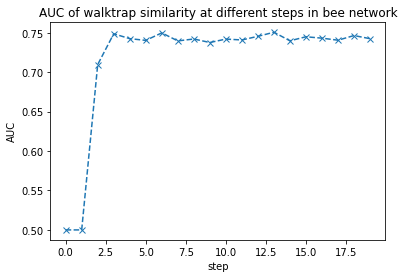

In [13]:
step = np.arange(0,20,1)
plt.plot(step,[AUC(Ga1,20,100,walktrap_similarity,t,probe_portion=0.1) for t in step],"x--")
plt.xlabel("step")
plt.ylabel("AUC")
plt.title("AUC of walktrap similarity at different steps in bee network")

Text(0.5, 1.0, 'AUC of walktrap similarity at different steps in ant network')

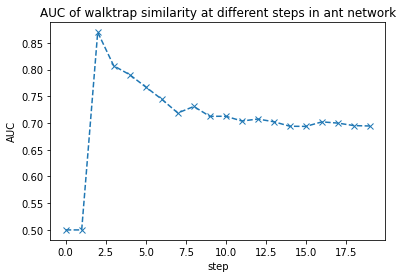

In [14]:
step = np.arange(0,20,1)
plt.plot(step,[AUC(Ants,20,100,walktrap_similarity,t,probe_portion=0.1) for t in step],"x--")
plt.xlabel("step")
plt.ylabel("AUC")
plt.title("AUC of walktrap similarity at different steps in ant network")

In [13]:
def antsbmauc(AUC=True):
    """Auc of SBM model in ant networks computed by graph-tool"""
    sbmauc = []
    sbmp = []
    for n in [1,2,3,4]:
        bee_auc = np.load(f"data/ant_ndcauc{n}.npy",allow_pickle=True)
        aucp = np.mean(bee_auc,axis=0)
        sbmauc.append(aucp[0])
        sbmp.append(aucp[1])
    if AUC:
        return sbmauc
    else:
        return sbmp

In [14]:
def beesbmauc(AUC=True):    
    sbmauc = []
    sbmp = []
    for n in [1,2,3,4]:
        bee_auc = np.load(f"data/bee_pre{n}.npy",allow_pickle=True)
        aucp = np.mean(bee_auc,axis=0)
        sbmauc.append(aucp[0])
        sbmp.append(aucp[1])
    if AUC:
        return sbmauc
    else:
        return sbmp

In [15]:
def f(x,a,b,c):
    return a-b*np.exp(-x/c)

In [16]:
def dp(t):
    """A simple fit of first and second slope against time."""
    if t >= 1000 and  t < 3000:
        a = 1.5
    elif t >= 3000 and t < 5000:
        a = 2.5
    elif t >= 5000 and t <= 7000:
        a = 4
    if t >= 1000 and t < 5000:
        b = 0.3
    else:
        b = 1/2000 * t - 2.3
    if t <= 1800:    
        c = f(t/1000,6.8565255402519325,18.950468304706803,0.6240970511448043)
    else: 
        c = np.log(241.72053667621356*t/1000-94.01767085703764)
    return a,b,c

In [17]:
def adjust_degree_product(G,t):
    """Adjusted degree product similarity."""
    a,b,c = dp(t)
    A = degree_product_similarity(G)
    B = A.copy()
    for i in range(len(A)):
        for j in range(len(A)):
            if A[i][j] and np.log(A[i][j]) < c-0.1:
                B[i][j] = A[i][j]**(a-1)
            elif A[i][j] and abs(c-np.log(A[i][j])) <= 0.1:
                B[i][j] = (np.exp(c-0.1))**(a-1)
            elif A[i][j] and np.log(A[i][j]) > c+0.1:
                B[i][j] = A[i][j]**(b-1) * (np.exp(c-0.1)) **(a-b)
    return B

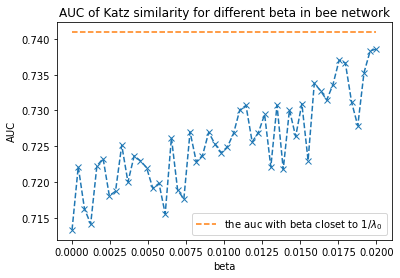

In [132]:
bee_kzx = np.linspace(0.00001,0.02,50)
plt.plot(bee_kzx,[AUC(Ga1,20,100,Katz_similarity,probe_portion=0.1,beta=x) for x in bee_kzx],"x--")
kzauc = AUC(Ga1,20,100,Katz_similarity,probe_portion=0.1,beta=0.0001,beta_max=True)
plt.plot(bee_kzx,[kzauc for n in range(len(bee_kzx))],"--",label=r"the auc with beta closet to 1/$\lambda_0$")
plt.xlabel("beta")
plt.ylabel("AUC")
plt.title("AUC of Katz similarity for different beta in bee network")
plt.legend()

Text(0.5, 1.0, 'AUC of Katz similarity for different beta in ant network')

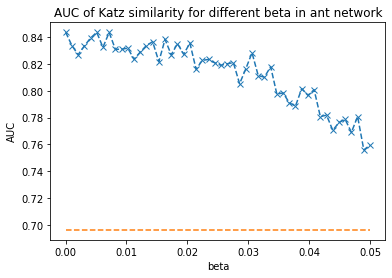

In [139]:
ant_kzx = np.linspace(0.00001,0.05,50)
plt.plot(ant_kzx,[AUC(Ants,20,100,Katz_similarity,probe_portion=0.1,beta=x) for x in ant_kzx],"x--")
ant_kzauc = AUC(Ants,20,100,Katz_similarity,probe_portion=0.1,beta=0.0001,beta_max=True)
plt.plot(ant_kzx,[ant_kzauc for n in range(len(ant_kzx))],"--",label=r"the auc with beta closet to 1/$\lambda_0$")
plt.xlabel("beta")
plt.ylabel("AUC")
plt.title("AUC of Katz similarity for different beta in ant network")

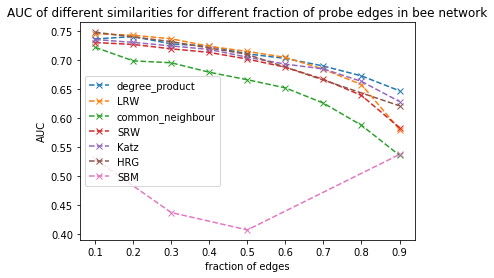

In [40]:
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,degree_product_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="degree_product")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,walktrap_similarity,3,probe_portion=0.1+0.1*n) for n in range(9)],"x--",label="LRW")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,common_neighbour_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="common_neighbour")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,SRW,3,probe_portion=0.1+0.1*n) for n in range(9)],"x--",label="SRW")
xauc = np.array([1,3,5,9])
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,Katz_similarity,probe_portion=0.1+0.1*n,
                                   beta=0.001,beta_max=True) for n in range(9)],"x--",label="Katz")
plt.plot(xauc/10,[hrgauc("bee",100,x) for x in xauc],"x--",label="HRG")
xauc2 = np.array([1,5,9])
plt.plot(xauc/10,beesbmauc(),"x--",label="SBM")
plt.xlabel("fraction of edges")
plt.ylabel("AUC")
plt.title("AUC of different similarities for different fraction of probe edges in bee network")
plt.legend()

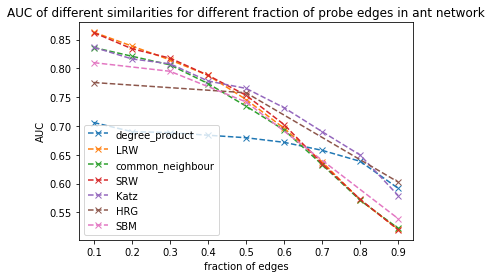

In [46]:
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,degree_product_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="degree_product")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,walktrap_similarity,2,probe_portion=0.1+0.1*n) for n in range(9)],"x--",label="LRW")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,common_neighbour_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="common_neighbour")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,walktrap_similarity,2,probe_portion=0.1+0.1*n) for n in range(9)],"x--",label="SRW")
xauc = np.array([1,5,9])
xauc2 = np.array([1,3,5,9])
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,Katz_similarity,probe_portion=0.1+0.1*n,beta=0.001) for n in range(9)],"x--",label="Katz")
plt.plot(xauc/10,[hrgauc("ant",100,x) for x in xauc],"x--",label="HRG")
plt.plot(xauc2/10,antsbmauc(),"x--",label="SBM")
plt.xlabel("fraction of edges")
plt.ylabel("AUC")
plt.title("AUC of different similarities for different fraction of probe edges in ant network")
plt.legend()

In [17]:
def hrg_score(colony,t,time_window,top_portion=1):
    '''Return the p_t of hrg.'''
    hrg_score_graph = nx.read_edgelist(f"data/{colony}_network_{t}.csv",data=(("prob",float),))
    new_edge_graph = nx.read_edgelist(f"data/{colony}_newedges_{t}-{t+time_window}.csv")
    new_edge_t = list(new_edge_graph.edges())
    n = int(len(new_edge_t)*top_portion)
    L = 0
    hrg_score_list = [d["prob"] for (u,v,d) in hrg_score_graph.edges(data=True)]
    hrg_score_list.sort(reverse=True)
    for e in hrg_score_graph.edges():
        if hrg_score_graph[e[0]][e[1]]["prob"] >= hrg_score_list[n-1] and ((e[0],e[1]) in new_edge_t or (e[1],e[0]) in new_edge_t):
            L += 1
    return L/n

In [18]:
def hrg_pre(colony,portion,top_portion=0.1,p_list=False):
    '''Return the precision of hrg.'''
    pre = 0
    pre_list = np.zeros(9)
    for iterate_number in range(1,6):
        auc_graph = nx.read_edgelist(f"data/{colony}_auc{portion}{iterate_number}.csv",data=(("prob",float),))
        probe_graph = nx.read_edgelist(f"data/{colony}_probeedges{portion}{iterate_number}.csv")
        probe_edges = list(probe_graph.edges())
        p = len(probe_graph.edges())
        q = min([p//2,100])
        r = int(p*top_portion)
        rank_list = [d["prob"] for (u,v,d) in auc_graph.edges(data=True)]
        rank_list.sort(reverse=True)
        L = len([e for e in probe_edges if auc_graph[e[0]][e[1]]["prob"] >= rank_list[r]]) 
        pre += L/r
        if p_list:
            L_list = np.array([len([e for e in probe_edges if auc_graph[e[0]][e[1]]["prob"] >= rank_list[int(p*tp)]]) 
                               for tp in np.arange(0.1,1,0.1)])
            r_list = np.array([int(p*tp) for tp in np.arange(0.1,1,0.1)])
            pre_list += L_list/r_list
    if p_list:
        return pre_list/iterate_number
    else:
        return pre/iterate_number

In [19]:
def precisiont(G,t,time_window,similarity,*o,top_portion=1,**kwarg):
    '''Return the p_t of a graph with respect to a certain similarity from time t to t+time_window'''
    Gt,new_edges = network_at_t(G,t,time_window)
    node_list = list(Gt.nodes())
    edge_list = list(Gt.edges())
    B = similarity(Gt,*o,**kwarg)
    n = len(Gt.nodes())
    L = 0
    rank_list = [B[i][j] for i in range(n) for j in range(i+1,n) if (node_list[i],node_list[j]) not in edge_list and 
                 (node_list[j],node_list[i]) not in edge_list]
    rank_list.sort(reverse=True)
    for e in new_edges:
        if e[0] in list(Gt.nodes()) and e[1] in list(Gt.nodes()):
            if B[node_index(Gt,e[0])][node_index(Gt,e[1])] >= rank_list[int(top_portion*len(new_edges))]:
                L += 1
    return L/int(top_portion*len(new_edges))

In [20]:
def precision(G,iterate_number,similarity,*o,probe_portion=0.1,top_portion=0.5,p_list=False,**kwarg):
    '''Return precision of a network with respect to a certain similarity. Argumetns are similar to AUC.'''
    average_auc = 0
    n = len(G.nodes())
    ne = len(G.edges())
    p = int(probe_portion*ne)
    q = min([p//3,100])
    r = int(p*top_portion)
    node_list = list(G.nodes())
    Hpotential_links = [(node_list[j],node_list[k]) for j in range(0,n) for k in range(j+1,n) \
                        if (node_list[j],node_list[k]) not in G.edges() and (node_list[k],node_list[j]) not in G.edges()]
    pre = 0
    pre_list = np.zeros(9)
    for iterate in range(iterate_number):
        H = G.copy()
        Hprobelinks = random.sample(list(H.edges()),p)
        H.remove_edges_from(Hprobelinks)
        B = similarity(H,*o,**kwarg)
        missing_index = [(node_index(G,e[0]),node_index(G,e[1])) for e in Hpotential_links + Hprobelinks]
        rank_list = [B[i][j] for (i,j) in missing_index]
        rank_list.sort(reverse=True)
        L = len([e for e in Hprobelinks if B[node_index(G,e[0])][node_index(G,e[1])] >= rank_list[r]])
        pre += L/r
        if p_list:
            L_list = np.array([len([e for e in Hprobelinks if B[node_index(G,e[0])][node_index(G,e[1])] >= rank_list[int(p*tp)]]) 
                               for tp in np.arange(0.1,1,0.1)])
            r_list = np.array([int(p*tp) for tp in np.arange(0.1,1,0.1)])
            pre_list += L_list/r_list
    if p_list:
        return pre_list/iterate_number
    else:
        return pre/iterate_number

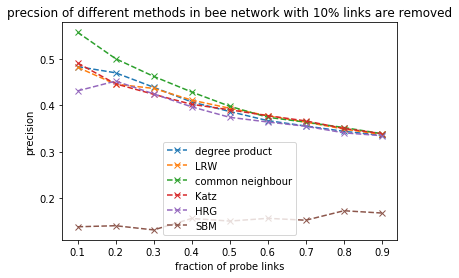

In [52]:
fra = np.arange(0.1,1,0.1)
plt.plot(fra,precision(Ga1,50,degree_product_similarity,probe_portion=0.1,p_list=True),"x--",label="degree product")
plt.plot(fra,precision(Ga1,50,walktrap_similarity,3,probe_portion=0.1,p_list=True),"x--",label="LRW")
plt.plot(fra,precision(Ga1,50,common_neighbour_similarity,probe_portion=0.1,p_list=True),"x--",label="common neighbour")
plt.plot(fra,precision(Ga1,50,Katz_similarity,probe_portion=0.1,beta_max=True,p_list=True),"x--",label="Katz")
plt.plot(fra,hrg_pre("bee",1,p_list=True),"x--",label="HRG")
plt.plot(fra,beesbmauc(AUC=False)[0],"x--",label="SBM")
plt.xlabel("fraction of probe links")
plt.ylabel("precision")
plt.title("precsion of different methods in bee network with 10% links are removed")
plt.legend()

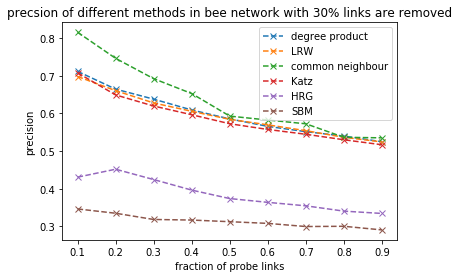

In [53]:
fra = np.arange(0.1,1,0.1)
plt.plot(fra,precision(Ga1,50,degree_product_similarity,probe_portion=0.3,p_list=True),"x--",label="degree product")
plt.plot(fra,precision(Ga1,50,walktrap_similarity,3,probe_portion=0.3,p_list=True),"x--",label="LRW")
plt.plot(fra,precision(Ga1,50,common_neighbour_similarity,probe_portion=0.3,p_list=True),"x--",label="common neighbour")
plt.plot(fra,precision(Ga1,50,Katz_similarity,probe_portion=0.3,beta_max=True,p_list=True),"x--",label="Katz")
plt.plot(fra,hrg_pre("bee",1,p_list=True),"x--",label="HRG")
plt.plot(fra,beesbmauc(AUC=False)[1],"x--",label="SBM")
plt.xlabel("fraction of probe links")
plt.ylabel("precision")
plt.title("precsion of different methods in bee network with 30% links are removed")
plt.legend()

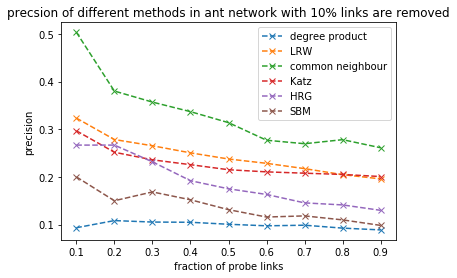

In [56]:
xauc2 = np.array([1,5,9])
fra = np.arange(0.1,1,0.1)
plt.plot(fra,precision(Ants,50,degree_product_similarity,probe_portion=0.1,p_list=True),"x--",label="degree product")
plt.plot(fra,precision(Ants,50,walktrap_similarity,2,probe_portion=0.1,p_list=True),"x--",label="LRW")
plt.plot(fra,precision(Ants,50,common_neighbour_similarity,probe_portion=0.1,p_list=True),"x--",label="common neighbour")
plt.plot(fra,precision(Ants,50,Katz_similarity,probe_portion=0.1,p_list=True,beta=0.01),"x--",label="Katz")
plt.plot(fra,hrg_pre("ant",1,p_list=True),"x--",label="HRG")
plt.plot(fra,antsbmauc(AUC=False)[0],"x--",label="SBM")
plt.xlabel("fraction of probe links")
plt.ylabel("precision")
plt.title("precsion of different methods in ant network with 10% links are removed")
plt.legend()

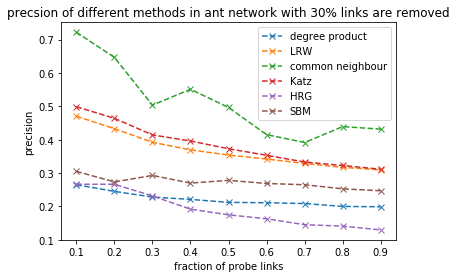

In [57]:
xauc2 = np.array([1,5,9])
fra = np.arange(0.1,1,0.1)
plt.plot(fra,precision(Ants,50,degree_product_similarity,probe_portion=0.3,p_list=True),"x--",label="degree product")
plt.plot(fra,precision(Ants,50,walktrap_similarity,2,probe_portion=0.3,p_list=True),"x--",label="LRW")
plt.plot(fra,precision(Ants,50,common_neighbour_similarity,probe_portion=0.3,p_list=True),"x--",label="common neighbour")
plt.plot(fra,precision(Ants,50,Katz_similarity,probe_portion=0.3,p_list=True,beta=0.01),"x--",label="Katz")
plt.plot(fra,hrg_pre("ant",1,p_list=True),"x--",label="HRG")
plt.plot(fra,antsbmauc(AUC=False)[1],"x--",label="SBM")
plt.xlabel("fraction of probe links")
plt.ylabel("precision")
plt.title("precsion of different methods in ant network with 30% links are removed")
plt.legend()

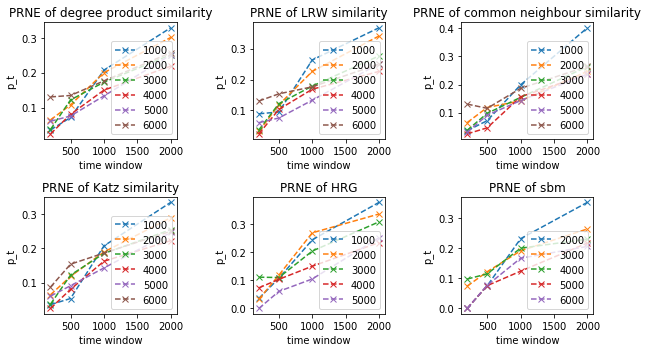

In [58]:
fig,ax = plt.subplots(figsize=(9,5))
plt.subplot(231)
time_interval = [200,500,1000,2000]
degree_product_p = np.zeros(4)
for n in range(6):
    p = [precisiont(Ga2,1000+n*1000,t,degree_product_similarity) for t in time_interval]
    degree_product_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of degree product similarity")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()

plt.subplot(232)
walktrap_p = np.zeros(4)
for n in range(6):
    p = [precisiont(Ga2,1000+n*1000,t,walktrap_similarity,3) for t in time_interval]
    walktrap_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of LRW similarity")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()

plt.subplot(233)
common_neighbour_p = np.zeros(4)
for n in range(6):
    p = [precisiont(Ga2,1000+n*1000,t,common_neighbour_similarity) for t in time_interval]
    common_neighbour_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of common neighbour similarity")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()

plt.subplot(234)
Katz_p = np.zeros(4)
for n in range(6):
    p = [precisiont(Ga2,1000+n*1000,t,Katz_similarity,beta_max=True) for t in time_interval]
    Katz_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of Katz similarity")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()

plt.subplot(235)
hrg_p = np.zeros(4)
for n in range(5):
    p = [hrg_score("bee",1000+n*1000,t) for t in time_interval]
    hrg_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of HRG")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()

plt.subplot(236)
sbm_p = np.zeros(4)
for n in range(1,6):
    p = np.load(f"data/bee_pt_{1000+n*1000}.npy")
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of sbm")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()
fig.tight_layout()

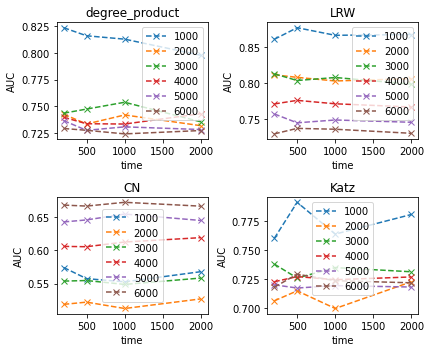

In [21]:
fig,ax = plt.subplots(figsize=(6,5))
time_interval = [200,500,1000,2000]
plt.subplot(221)
dp_auc = []
for n in range(6):
    p = [AUC(network_at_t(Ga2,1000+n*1000,t)[0],20,50,degree_product_similarity) for t in time_interval]
    dp_auc.append(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("degree_product")
plt.xlabel("time")
plt.ylabel("AUC")
plt.legend()

plt.subplot(222)
wp_auc = []
for n in range(6):
    p = [AUC(network_at_t(Ga2,1000+n*1000,t)[0],20,50,walktrap_similarity,3) for t in time_interval]
    wp_auc.append(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("LRW")
plt.xlabel("time")
plt.ylabel("AUC")
plt.legend()

plt.subplot(223)
cn_auc = []
for n in range(6):
    p = [AUC(network_at_t(Ga2,1000+n*1000,t)[0],20,50,common_neighbour_similarity) for t in time_interval]
    cn_auc.append(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("CN")
plt.xlabel("time")
plt.ylabel("AUC")
plt.legend()

plt.subplot(224)
Katz_auc = []
for n in range(6):
    p = [AUC(network_at_t(Ga2,1000+n*1000,t)[0],20,50,Katz_similarity,beta_max=True) for t in time_interval]
    Katz_auc.append(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("Katz")
plt.xlabel("time")
plt.ylabel("AUC")
plt.legend()
fig.tight_layout()

In [30]:
def AUCRNE(G,t,time_window,sample_time,similarity,*o,**kwarg):
    Gt,new_edges = network_at_t(G,t,time_window)
    node_list = list(G.nodes())
    edge_list = list(G.edges())
    n = len(node_list)
    p = len(new_edges)
    q = p//2
    B = similarity(Gt,*o,**kwarg)
    Hpotential_links = [(node_list[j],node_list[k]) for j in range(0,n) for k in range(j+1,n)
                        if (node_list[j],node_list[k]) not in G.edges() and (node_list[k],node_list[j]) not in G.edges()]
    node_list2 = list(Gt.nodes())
    auc = 0
    for sample in range(sample_time):
        probe_sample = random.sample(new_edges,q)
        potential_sample = random.sample(Hpotential_links,q)
        m1,m2 = 0,0
        for i in range(q):
            e1 = probe_sample[i]
            e2 = potential_sample[i]
            if e1[0] in node_list2 and e1[1] in node_list2 and e2[0] in node_list2 and e2[1] in node_list2:
                if B[node_index(Gt,e1[0])][node_index(Gt,e1[1])] > B[node_index(Gt,e2[0])][node_index(Gt,e2[1])]:
                    m1 += 1
                elif B[node_index(Gt,e1[0])][node_index(Gt,e1[1])] == B[node_index(Gt,e2[0])][node_index(Gt,e2[1])]:
                    m2 += 1
        auc += (m1 + 0.5*m2)/q
    return auc/sample_time

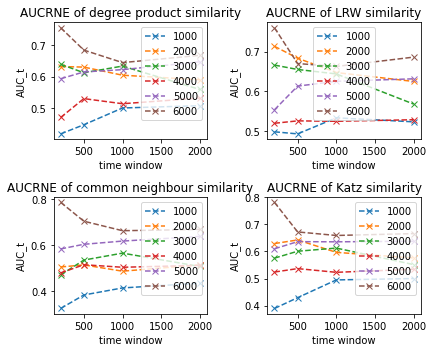

In [205]:
fig,ax = plt.subplots(figsize=(6,5))
plt.subplot(221)
time_interval = [200,500,1000,2000]
degree_product_p = np.zeros(4)
for n in range(6):
    p = [AUCRNE(Ga2,1000+n*1000,t,50,degree_product_similarity) for t in time_interval]
    degree_product_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("AUCRNE of degree product similarity")
plt.xlabel("time window")
plt.ylabel("AUC_t")
plt.legend()

plt.subplot(222)
walktrap_p = np.zeros(4)
for n in range(6):
    p = [AUCRNE(Ga2,1000+n*1000,t,50,walktrap_similarity,3) for t in time_interval]
    walktrap_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("AUCRNE of LRW similarity")
plt.xlabel("time window")
plt.ylabel("AUC_t")
plt.legend()

plt.subplot(223)
common_neighbour_p = np.zeros(4)
for n in range(6):
    p = [AUCRNE(Ga2,1000+n*1000,t,50,common_neighbour_similarity) for t in time_interval]
    common_neighbour_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("AUCRNE of common neighbour similarity")
plt.xlabel("time window")
plt.ylabel("AUC_t")
plt.legend()

plt.subplot(224)
Katz_p = np.zeros(4)
for n in range(6):
    p = [AUCRNE(Ga2,1000+n*1000,t,50,Katz_similarity,beta_max=True) for t in time_interval]
    Katz_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("AUCRNE of Katz similarity")
plt.xlabel("time window")
plt.ylabel("AUC_t")
plt.legend()
fig.tight_layout()

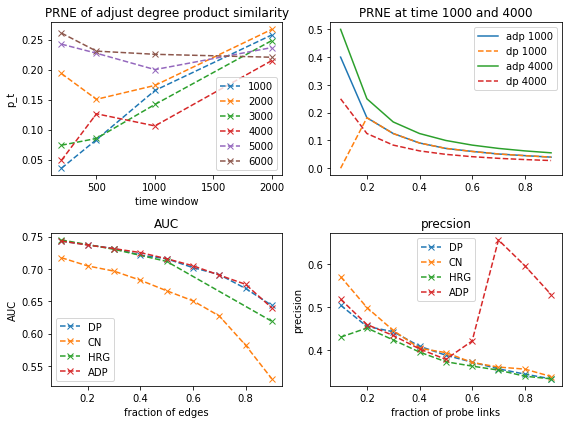

In [28]:
time_interval = [200,500,1000,2000]
fig,ax = plt.subplots(figsize=(8,6))
fra = np.arange(0.1,1,0.1)
plt.subplot(221)
adp_p = np.zeros(4)
for n in range(6):
    p = [precisiont(Ga2,1000+n*1000,t,adjust_degree_product,1000+n*1000) for t in time_interval]
    adp_p += np.array(p)
    plt.plot(time_interval,p,"x--",label=f"{1000+n*1000}")
plt.title("PRNE of adjust degree product similarity")
plt.xlabel("time window")
plt.ylabel("p_t")
plt.legend()

plt.subplot(222)
p1 = [precisiont(Ga2,1000,200,adjust_degree_product,1000,top_portion=tp) for tp in fra]
p2 = [precisiont(Ga2,1000,200,degree_product_similarity,top_portion=tp) for tp in fra]
p3 = [precisiont(Ga2,4000,200,adjust_degree_product,4000,top_portion=tp) for tp in fra]
p4 = [precisiont(Ga2,4000,200,degree_product_similarity,top_portion=tp) for tp in fra]
plt.plot(fra,p1,label=f"adp 1000")
plt.plot(fra,p2,"--",label=f"dp 1000")
plt.plot(fra,p3,label=f"adp 4000")
plt.plot(fra,p4,"--",label=f"dp 4000")
plt.title("PRNE at time 1000 and 4000")
plt.legend()

plt.subplot(223)
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,degree_product_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="DP")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,common_neighbour_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="CN")
xauc = np.array([1,3,5,9])
plt.plot(xauc/10,[hrgauc("bee",100,x) for x in xauc],"x--",label="HRG")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ga1,20,100,adjust_degree_product,7000,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="ADP")
xauc2 = np.array([1,5,9])
plt.xlabel("fraction of edges")
plt.ylabel("AUC")
plt.title("AUC")
plt.legend()

plt.subplot(224)
plt.plot(fra,precision(Ga1,50,degree_product_similarity,probe_portion=0.1,p_list=True),"x--",label="DP")
plt.plot(fra,precision(Ga1,50,common_neighbour_similarity,probe_portion=0.1,p_list=True),"x--",label="CN")
plt.plot(fra,hrg_pre("bee",1,p_list=True),"x--",label="HRG")
plt.plot(fra,precision(Ga1,50,adjust_degree_product,7000,probe_portion=0.1,p_list=True),"x--",label="ADP")
plt.xlabel("fraction of probe links")
plt.ylabel("precision")
plt.title("precsion")
plt.legend()
fig.tight_layout()

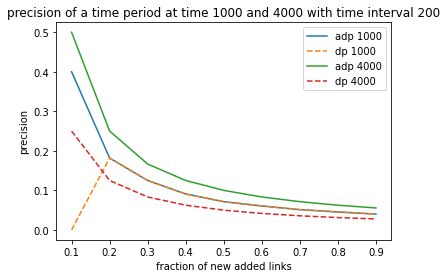

In [24]:
fra = np.arange(0.1,1,0.1)
p1 = [precisiont(Ga2,1000,200,adjust_degree_product,1000,top_portion=tp) for tp in fra]
p2 = [precisiont(Ga2,1000,200,degree_product_similarity,top_portion=tp) for tp in fra]
p3 = [precisiont(Ga2,4000,200,adjust_degree_product,4000,top_portion=tp) for tp in fra]
p4 = [precisiont(Ga2,4000,200,degree_product_similarity,top_portion=tp) for tp in fra]
plt.plot(fra,p1,label=f"adp 1000")
plt.plot(fra,p2,"--",label=f"dp 1000")
plt.plot(fra,p3,label=f"adp 4000")
plt.plot(fra,p4,"--",label=f"dp 4000")
plt.title("precision of a time period at time 1000 and 4000 with time interval 200")
plt.xlabel("fraction of new added links")
plt.ylabel("precision")
plt.legend()

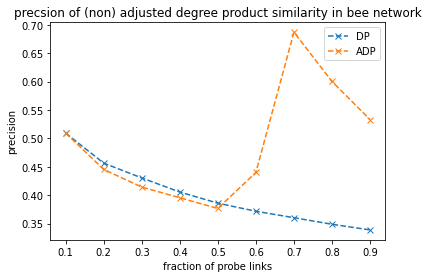

In [24]:
plt.plot(fra,precision(Ga1,50,degree_product_similarity,probe_portion=0.1,p_list=True),"x--",label="DP")
plt.plot(fra,precision(Ga1,50,adjust_degree_product,7000,probe_portion=0.1,p_list=True),"x--",label="ADP")
plt.xlabel("fraction of probe links")
plt.ylabel("precision")
plt.title("precsion of (non) adjusted degree product similarity in bee network")
plt.legend()

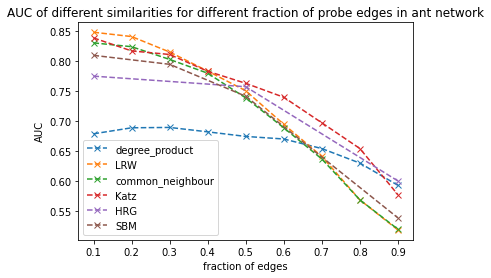

In [15]:
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,degree_product_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="degree_product")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,walktrap_similarity,2,probe_portion=0.1+0.1*n) for n in range(9)],"x--",label="LRW")
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,common_neighbour_similarity,probe_portion=0.1+0.1*n) 
                               for n in range(9)],"x--",label="common_neighbour")
xauc = np.array([1,5,9])
xauc2 = np.array([1,3,5,9])
plt.plot(np.arange(0.1,1,0.1),[AUC(Ants,20,100,Katz_similarity,probe_portion=0.1+0.1*n,beta=0.001) for n in range(9)],"x--",label="Katz")
plt.plot(xauc/10,[hrgauc("ant",100,x) for x in xauc],"x--",label="HRG")
plt.plot(xauc2/10,antsbmauc(),"x--",label="SBM")
plt.xlabel("fraction of edges")
plt.ylabel("AUC")
plt.title("AUC of different similarities for different fraction of probe edges in ant network")
plt.legend()